In [1]:
#import libraries
import time
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pdb
import h5py
import my_callbacks
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from CRNN_tensor import MusicTaggerCRNN
from sklearn.metrics import roc_curve,auc,roc_auc_score
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
#load the dataset
dataset = h5py.File('train.h5', 'r')
train_x = dataset.get('melgram')
train_y = dataset.get('y')
dataset = h5py.File('valid.h5', 'r')
valid_x = dataset.get('melgram')
valid_y = dataset.get('y')
dataset = h5py.File('test.h5', 'r')
test_x = dataset.get('melgram')
test_y = dataset.get('y')

In [4]:
def main(net):

    print('Running main() with network: %s and backend: %s' % (net, K._BACKEND))

    #load model
    if net == 'crnn':
        model = MusicTaggerCRNN(weights=None)

    #print input shape
    print("Expected input shape: ",model.input_shape)
    print("Actual input shape: ",train_x.shape)
    
    #print model info
    model.summary()

    #compile model
    print("Compiling")
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #prepare callbacks
    histories = my_callbacks.Histories()
    checkpoint= ModelCheckpoint(filepath="model.hdf5",monitor='val_loss', verbose=0,save_best_only=True, mode='auto')
    callbacks_list=[histories,checkpoint]
    
    #train model
    print("Training")
    nb_epoch = 30
    model.fit(train_x, train_y, batch_size=32, nb_epoch=30, verbose=1,callbacks=callbacks_list,validation_data=(valid_x,valid_y),shuffle="batch")
    
    #print AUC scores
    print("\nAUCs:")
    for index,auc_score in enumerate(histories.aucs):
        print(index,":",auc_score)

        
    #print final AUC, accuracy 
    print("\ntesting on ",test_x.shape[0]," samples")
    scores = model.evaluate(test_x, test_y)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    y_score = model.predict(test_x)
    fpr, tpr, _ = roc_curve(test_y[:,0],y_score[:, 0])
    roc_auc = auc(fpr, tpr)
    print("AUC: %f" % roc_auc)
    
    #plot ROC
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0,1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
       
    #auc vs epochs
    epoch_y = list(range(1,nb_epoch+1))
    plt.title('AUC scores vs epoch')
    plt.xticks(np.arange(1,nb_epoch+1,3))
    plt.plot(epoch_y,histories.aucs)
    plt.xlim([1, nb_epoch+1])
    plt.xlabel('Number of epochs')
    plt.ylabel('AUC')
    plt.show()
    
    #loss vs epochs
    epoch_y = list(range(1,nb_epoch+1))
    plt.title('Model Loss')
    plt.xticks(np.arange(1,nb_epoch+1,3))
    plt.plot(epoch_y,histories.loss, color='blue')
    plt.plot(epoch_y,histories.valloss, color='green')
    plt.xlim([1, nb_epoch+1])
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
    #save model
    model_json = model.to_json()
    with open("model.json","w") as json_file:
        json_file.write(model_json)
    model.save_weights('weights.h5')
    print("Saved model to disk")

Running main() with network: crnn and backend: tensorflow
(?, 96, 1366, 1)
(?, 1, 15, 128)
(?, 40)
Expected input shape:  (None, 96, 1366)
Actual input shape:  (18102, 96, 1366)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 96, 1366)      0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 96, 1366, 1)   0           input_1[0][0]                    
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 96, 1440, 1)   0           reshape_1[0][0]                  
____________________________________________________________________________________________________
bn_0_freq (Bat

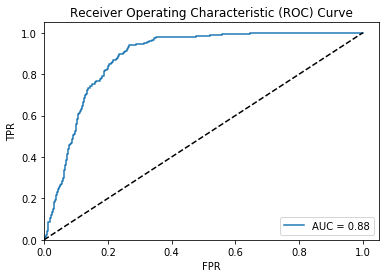

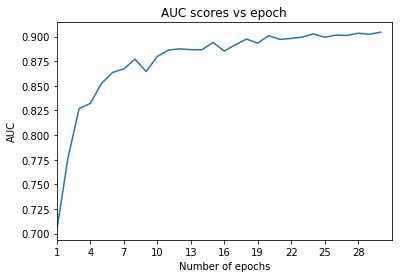

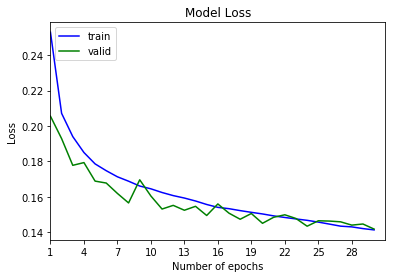

Saved model to disk


In [5]:
#main function
if __name__ == '__main__':

    networks = ['crnn']
    for net in networks:
    	main(net)